import sys
!{sys.executable} -m pip install pydot

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx
import networkx.convert_matrix as nx
import pyvis
import graphviz
from pyvis.network import Network
import pyvis.network as net
import pydot
import random
import time
# https://towardsdatascience.com/social-network-analysis-from-theory-to-applications-with-python-d12e9a34c2c7
# https://github.com/ewenme/transfers
# https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259
# https://github.com/MridulS/pydata-networkx
# https://datapane.com/u/khuyentran1401/reports/63OQaRk/pyvis-visualize-interactive-network-graphs-in-python/

In [58]:
BuLi19 = pd.read_csv("2019_german_bundesliga_1.csv")
PL19 = pd.read_csv("2019_english_premier_league.csv")
SA19 = pd.read_csv("2019_italian_serie_a.csv")
PD19 = pd.read_csv("2019_spanish_primera_division.csv")
L1_19 = pd.read_csv("2019_french_ligue_1.csv")
NOS19 = pd.read_csv("2019_portugese_liga_nos.csv")
Ere19 = pd.read_csv("2019_dutch_eredivisie.csv")
EC19 = pd.read_csv("2019_english_championship.csv")
Rus19 = pd.read_csv("2019_russian_premier_liga.csv")

In [59]:
DF19 = pd.concat([BuLi19, PL19, SA19,
                  PD19, L1_19, NOS19, 
                  Ere19, EC19, Rus19])

In [60]:
DF19.shape

(7279, 12)

In [61]:
DF19["club_name"].isin(["Leicester City"])

0      False
1      False
2      False
3      False
4      False
       ...  
582    False
583    False
584    False
585    False
586    False
Name: club_name, Length: 7279, dtype: bool

In [62]:
## There is a problem with Leicester City and Paderborn
DF19.loc[DF19["club_name"].isin(["Leicester"]), ["club_name"]] = "Leicester City"
DF19.loc[DF19["club_involved_name"].isin(["Leicester"]), ["club_involved_name"]] = "Leicester City"

DF19.loc[DF19["club_name"].isin(["SC Paderborn"]), ["club_name"]] = "SC Paderborn 07"
DF19.loc[DF19["club_involved_name"].isin(["SC Paderborn"]), ["club_involved_name"]] = "SC Paderborn 07"

In [63]:
sum(DF19["club_involved_name"].isin(["Leicester"]))

0

## Clean the Data

In [64]:
def DelCol(DF):
    DF = DF.loc[DF["transfer_movement"]=="in"] # only one direction of transfers should be considered
    DF = DF.loc[DF["fee_cleaned"]>0] # only "real" transfers
    del DF["player_name"]
    del DF["transfer_movement"]
    del DF["age"]
    del DF["position"]
    del DF["fee"]
    del DF["league_name"]
    del DF["transfer_period"]
    del DF["year"]
    del DF["season"]
    return(DF)



In [65]:
DF19 = DelCol(DF19)

In [66]:
BuLi19["colour"] = "red"
print(BuLi19)

             club_name        player_name  age            position  \
0        Bayern Munich    Lucas Hernández   23         Centre-Back   
1        Bayern Munich    Benjamin Pavard   23          Right-Back   
2        Bayern Munich   Michaël Cuisance   20    Central Midfield   
3        Bayern Munich  Philippe Coutinho   27  Attacking Midfield   
4        Bayern Munich       Ivan Perisic   30         Left Winger   
..                 ...                ...  ...                 ...   
585  1.FC Union Berlin        Yunus Malli   27  Attacking Midfield   
586  1.FC Union Berlin      Lennart Moser   20          Goalkeeper   
587  1.FC Union Berlin    Lennard Maloney   20         Centre-Back   
588  1.FC Union Berlin       Nicolai Rapp   23         Centre-Back   
589  1.FC Union Berlin      Lennart Moser   20          Goalkeeper   

    club_involved_name                      fee transfer_movement  \
0      Atlético Madrid                  £72.00m                in   
1        VfB Stuttgar

### Combine multiple transfers between clubs a and b

In [67]:
# now as a function
        
def AddFees(DF): # adds fees of multiple transfers from club a to b
    # output
    DF_out = pd.DataFrame({'club_name' : [],
                         "club_involved_name":[],
                         "fee_cleaned":[]})
    
    for i in range(DF.shape[0]):
        # is this a new match?
        if DF_out.loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])].size ==0:
            DF_out = DF_out.append(DF.iloc[i])
        else:
            # add fee value to already existing value
            DF_out["fee_cleaned"].loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])] += DF["fee_cleaned"].iloc[i]
            
    return(DF_out)    
        

In [68]:
DF19 = AddFees(DF19)

/home/users/t_wand01/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [69]:
DF19

,club_name,club_involved_name,fee_cleaned
0,Bayern Munich,Atlético Madrid,72.000
1,Bayern Munich,VfB Stuttgart,31.500
2,Bayern Munich,Bor. M'gladbach,10.800
3,Bayern Munich,FC Barcelona,7.650
4,Bayern Munich,Inter,4.500
...,...,...,...
537,Dynamo Moscow,Mladá Boleslav,3.150
545,Krylya Sovetov Samara,Al-Shorta SC,0.135
558,FK Ufa,Loko Tashkent,0.180
559,FK Ufa,Anzhi,0.162


## Second Data Set: Undirected
Combine both transfer fees from A to B and B to A as one "transfer volume"

In [70]:
DFun19 =  pd.DataFrame({'club1' : [],
                         "club2":[],
                         "fee_cleaned":[]})

In [71]:
DFun19["club1"] = np.minimum(DF19['club_name'], DF19['club_involved_name']) 
DFun19["club2"] = np.maximum(DF19['club_name'], DF19['club_involved_name']) 

In [72]:
       
def AddFeesUndirected(DF): # adds fees of multiple transfers from club a to b
    # output
    DF_out = pd.DataFrame({'club_name' : [],
                         "club_involved_name":[],
                         "fee_cleaned":[]})
    
    for i in range(DF.shape[0]):
        # is this a new match?
        
        if ((DF_out.loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])].size ==0) and 
            (DF_out.loc[(DF_out["club_involved_name"]== DF["club_name"].iloc[i])&  # Neither direction!
                     DF_out["club_name"].isin([DF["club_involved_name"].iloc[i]])].size ==0)):
            DF_out = DF_out.append(DF.iloc[i])
        
        elif (DF_out.loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])].size > 0):
            # add fee value to already existing value
            DF_out["fee_cleaned"].loc[(DF_out["club_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_involved_name"].isin([DF["club_involved_name"].iloc[i]])] += DF["fee_cleaned"].iloc[i]
        
        else: # add the "reversed" fee to existing value
            DF_out["fee_cleaned"].loc[(DF_out["club_involved_name"]== DF["club_name"].iloc[i])&  
                     DF_out["club_name"].isin([DF["club_involved_name"].iloc[i]])] += DF["fee_cleaned"].iloc[i]
            
            
    return(DF_out)    
        

In [73]:
DFun19 = AddFeesUndirected(DF19)

/home/users/t_wand01/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# Graphs

In [74]:
G = nx.from_pandas_edgelist(DF19, 
                            source = "club_name",
                            target = "club_involved_name",
                            edge_attr=["fee_cleaned"],#, "colour"],
                            create_using=networkx.DiGraph()
                           )

In [75]:
# Teams of individual leagues 19/20
BL19_teams = list(set(BuLi19["club_name"])) # Bundesliga
BL19List = pd.Series(BL19_teams)

PL19List = pd.Series(list(set(PL19["club_name"])))
SA19List = pd.Series(list(set(SA19["club_name"])))
PD19List = pd.Series(list(set(PD19["club_name"])))
L119List = pd.Series(list(set(L1_19["club_name"])))




l = ["red", "blue"]
print(len(G.nodes))
Colours = random.choices(l, k=len(G.nodes))

In [76]:
Colours = ["none"]*len(G.nodes)
j = 0
for i in G.nodes:
    if np.sum(BL19List.isin([i])) > 0: # if Bundesliga-Team
        Colours[j] = "red"
    j = j+1

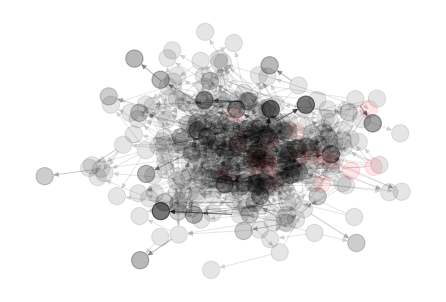

In [77]:
networkx.draw_kamada_kawai(G,node_color = Colours, with_labels=False, alpha=0.1)

In [78]:
def Colour1(node):
    if np.sum(BL19List.isin([node])):
        out = "red"
    elif np.sum(PL19List.isin([node])):
        out = "blue"
    elif np.sum(SA19List.isin([node])):
        out = "green" 
    elif np.sum(PD19List.isin([node])):
        out = "yellow"
    elif np.sum(L119List.isin([node])):
        out = "purple"
    else:
        out = "none"
    return(out)

In [79]:
j = 0
for i in G.nodes:
    Colours[j] = Colour1(i)
    j = j+1

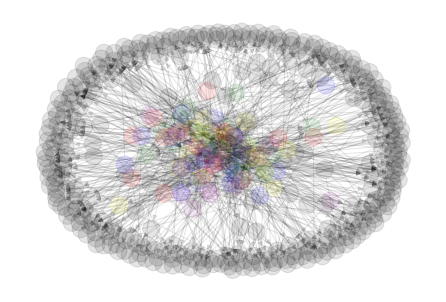

In [80]:
networkx.draw_spring(G,node_color = Colours, with_labels=False, alpha = 0.1)

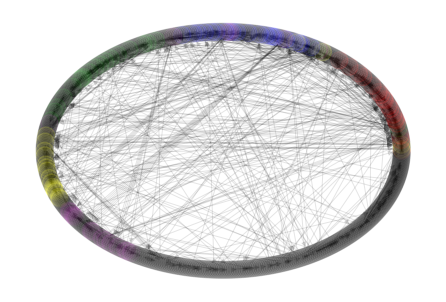

In [81]:
networkx.draw_circular(G,node_color = Colours, with_labels=False, alpha = 0.1)
# one can see blocks of the individual countries + crosslinks

In [82]:
net = Network("800px", "800px",notebook=True)
net.from_nx(G)
net.show("Test.html")
# net.save_graph("Test.html")

## Pyvis

In [83]:
g = Network(notebook=True)
G = nx.from_pandas_edgelist(DFun19, 
                            source = "club_involved_name",
                            target = "club_name",
                            edge_attr=["fee_cleaned"],#, "colour"],
                            create_using=networkx.DiGraph()
                           )

g.add_nodes(np.array(G.nodes), 
            color = random.choices(["red","grey"], k=len(G.nodes)),
            options = {
                "title":"lel"
            })

In [84]:
def Colour(node):
    # from https://www.hexcolortool.com/#f429ff,0.33
    if np.sum(BL19List.isin([node])):
        out = "rgba(244, 15, 11, 0.66)"
    elif np.sum(PL19List.isin([node])):
        out = "rgba(41, 155, 255, 0.66)"
    elif np.sum(SA19List.isin([node])):
        out = "rgba(41, 255, 77, 0.66)" 
    elif np.sum(PD19List.isin([node])):
        out = "rgba(255, 241, 41, 0.66)"
    elif np.sum(L119List.isin([node])):
        out = "rgba(244, 41, 255, 0.66)"
    else:
        out = "rgba(0, 0, 0, 0.22)"
    return(out)

In [85]:
# https://www.hexcolortool.com/#f40f0b,0.33
for node in G.nodes:
    g.add_node(str(node), color = Colour(node), #alpha=0.1,
              options = {
              })

In [86]:
#var options = {
# "nodes": {
#    "color": {
#      "border": "rgba(43,124,233,0.46)",
#      "background": "rgba(90,65,252,0.51)"
#    }
#  },
#  "edges": {
#    "color": {
#      "inherit": true
#    },
#    "smooth": false
#  },
#  "physics": {
# "enabled": false,
#    "repulsion": {
#     "springLength": 500
#   },
#    "minVelocity": 0.75,
#    "solver": "repulsion"
#  }
#}

In [87]:
#g.add_edges(DF19["club_name"],DF19["club_involved_name"], value =DF19["fee_cleaned"])

In [88]:
for i in range(DFun19.shape[0]):
    g.add_edge(DFun19["club_name"].iloc[i], 
              DFun19["club_involved_name"].iloc[i],
              value=DFun19["fee_cleaned"].iloc[i], 
            kwargs ={
               "physics":False
           })


In [89]:
g.show("Test.html")

In [90]:
g.save_graph("2019_allLeagues.html")

In [91]:
DF19.shape[0]

851

## Analysis

In [92]:
G_undir = nx.from_pandas_edgelist(DFun19, 
                            source = "club_name",
                            target = "club_involved_name",
                            edge_attr="fee_cleaned",
                            create_using=networkx.Graph # or Graph, DiGraph, MultiGraph, MultiDiGraph
                           )

#### Small World

In [93]:
## Small world

# random reference graph
#G_ref = networkx.algorithms.smallworld.random_reference(G_undir, seed = 10)
#DFcon19 = DFun19.iloc[DFun19["club_name"]!="SC Paderborn 07"]
#DFcon19 = DFcon19.iloc[DFcon19["club_involved_name"]!="SC Paderborn 07"]
SepList = ["Vitória Setúbal FC","RKC Waalwijk","Spartak", "Charlton Athletic","Covilhã","Luton Town",
           "Queens Park Rangers","Portimonense SC","Vitória Guimarães SC","FK Ufa", "VfL Bochum"]

DFcon19 = DFun19.drop(DFun19[ DFun19['club_name'].isin( SepList)].index)
DFcon19 = DFcon19.drop(DFcon19[ DFcon19['club_involved_name'].isin(SepList)].index)

#networkx.algorithms.smallworld.sigma(G_undir,niter=10, seed=10)

In [94]:
DFcon19

,club_name,club_involved_name,fee_cleaned
0,Bayern Munich,Atlético Madrid,72.000
1,Bayern Munich,VfB Stuttgart,31.500
2,Bayern Munich,Bor. M'gladbach,10.800
3,Bayern Munich,FC Barcelona,7.650
4,Bayern Munich,Inter,4.500
...,...,...,...
525,Rubin Kazan,Torpedo Moscow,0.045
536,Dynamo Moscow,Krasnodar,3.870
537,Dynamo Moscow,Mladá Boleslav,3.150
545,Krylya Sovetov Samara,Al-Shorta SC,0.135


In [95]:
G_undirconnected = nx.from_pandas_edgelist(DFcon19, 
                            source = "club_name",
                            target = "club_involved_name",
                            edge_attr="fee_cleaned",
                            create_using=networkx.Graph # or Graph, DiGraph, MultiGraph, MultiDiGraph
                           )




In [96]:
Colour("SC Paderborn 07")

'rgba(244, 15, 11, 0.66)'

In [97]:
# Quick check: plot
nt = Network('800px', '800px',notebook=True)
#nt.from_nx(G_undirconnected)


for node in G_undirconnected.nodes:
    nt.add_node(str(node), color = Colour(node), #alpha=0.1,
              options = {
              })
    
for i in range(DFcon19.shape[0]):
    nt.add_edge(DFcon19["club_name"].iloc[i], 
              DFcon19["club_involved_name"].iloc[i],
              value=DFcon19["fee_cleaned"].iloc[i], 
            kwargs ={
               "physics":False
           })

nt.show('nx.html')
# Is connected!!

In [98]:
nt.save_graph("2019_connection.html")

In [104]:

start = time.time()

SW = networkx.algorithms.smallworld.sigma(G_undirconnected,niter=20, seed=10)
print(SW)

end = time.time()
print(end - start)

1.4126266711963913
509.8205089569092


#### Scaling Behaviour

In [83]:
networkx.classes.function.degree_histogram(G_undir)

[0, 140, 42, 26, 23, 22, 27, 10, 13, 6, 7, 4, 6, 2, 3, 1, 1, 1, 2]

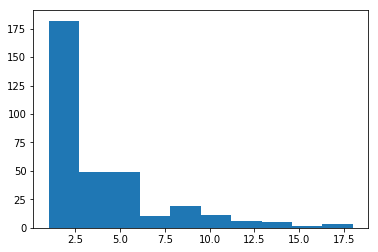

In [84]:
import networkx as nx

def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()

plot_degree_dist(G_undir)

In [72]:
from networkx.algorithms import approximation

approximation.average_clustering(G_undir, trials=1000, seed=10)

0.024

In [65]:
networkx.algorithms.approximation.connectivity.all_pairs_node_connectivity(G_undir)

{'Bayern Munich': {'Atlético Madrid': 1,
  'VfB Stuttgart': 9,
  "Bor. M'gladbach": 5,
  'FC Barcelona': 3,
  'Inter': 2,
  'Hamburger SV': 6,
  'FC Bayern II': 3,
  'Werder Bremen': 6,
  'Bor. Dortmund': 7,
  'LOSC Lille': 1,
  'Flamengo': 1,
  'Fiorentina': 1,
  'Career break': 1,
  'Real Madrid': 2,
  'Borussia Dortmund': 10,
  'TSG Hoffenheim': 9,
  'Bay. Leverkusen': 4,
  'Barça U19': 1,
  'B. Dortmund U19': 1,
  'Norwich': 6,
  'Fulham': 2,
  'E. Frankfurt': 4,
  'Willem II': 2,
  'Besiktas': 1,
  'Celtic': 2,
  'Paris SG': 4,
  'Dynamo Moscow': 1,
  'Real Sociedad': 1,
  'Real Zaragoza': 1,
  'Sassuolo': 1,
  'Hertha BSC': 12,
  'Spartak Moscow': 1,
  'Fortuna Sittard': 2,
  'SD Huesca': 2,
  'Chelsea': 3,
  'RB Leipzig': 9,
  'Everton': 3,
  'RB Salzburg': 5,
  'Palmeiras U20': 1,
  'AS Roma': 1,
  'Hannover 96': 9,
  'RB Leipzig U19': 1,
  'PSV Eindhoven': 2,
  'Monaco': 2,
  '1. FC Köln': 11,
  'Göztepe': 1,
  'FC Luzern': 2,
  'Arsenal U23': 2,
  'Bayer 04 Leverkusen': 10,
 

### Directed

In [73]:
G_dir = nx.from_pandas_edgelist(DF19, 
                            source = "club_involved_name",
                            target = "club_name",
                            edge_attr="fee_cleaned",
                            create_using=networkx.MultiDiGraph # or Graph, DiGraph, MultiGraph, MultiDiGraph
                           )

In [74]:
networkx.algorithms.hierarchy.flow_hierarchy(G_dir)

0.975767366720517